# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [2]:
import os
import keras
import tensorflow as tf
# Disable GPU
# 本作業可以不需使用 GPU, 將 GPU 設定為 "無" (若想使用可自行開啟)
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.65) #占用65%顯存
sess =  tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
         # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """
    Build your own model
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            #Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            #Dense是全連接層，該層的輸出維度n_units，激活函數='relu'
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
           #Dense是全連接層，該層的輸出維度n_units，激活函數='softmax'
    
    #定義一個具有輸入和輸出的模型
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model 

In [7]:
## 超參數設定
"""
Set your required experiment parameters
"""
LEARNING_RATE = [0.001, 0.01, 0.1, 1] #學習率
EPOCHS = 50 #訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 256 #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = [0.8] #動量
nesteror=[True] #Nesterov動量

In [8]:
results = {}
"""
建立你的訓練與實驗迴圈並蒐集資料
"""
"""
使用迴圈，建立不同 Learning rate 的模型並訓練
"""
for lr in LEARNING_RATE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f" % (lr))
    model = build_mlp(input_shape=x_train.shape[1:])
    # 用 Keras 內建方法檢視模型各層參數量
    model.summary()
    #優化器參數設定
    optimizer = keras.optimizers.SGD(lr=lr, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    '''
    參數說明:
    lr：float> = 0.學習率。
    momentum：float> =0。參數，用於加速SGD在相關方向上前進，並抑制震盪。
    decay：float> =0。每次參數更新後學習率衰減值。
    nesterov：布林值。是否使用Nesterov動量。
    '''
    
    model.fit(x_train, y_train, #訓練資料
              epochs=EPOCHS,   #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test),  #驗證資料
              shuffle=True) #每次epochs後，將訓練集打亂順序
    
    # Collect results
    #ㄘhistory.history:記錄了損失函數和其他指標的數值隨epoch變化的情況，如果有驗證集的話，也包含了驗證集的這些指標變化情況
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s" % str(lr)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}


Experiment with LR = 0.001000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [===========

50000/50000 [==============================] - 2s 49us/step - loss: 1.3453 - accuracy: 0.5284 - val_loss: 1.4247 - val_accuracy: 0.4951
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 1.3394 - accuracy: 0.5310 - val_loss: 1.4244 - val_accuracy: 0.4961
Experiment with LR = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (D

50000/50000 [==============================] - 2s 48us/step - loss: 0.9301 - accuracy: 0.6639 - val_loss: 1.7619 - val_accuracy: 0.4704
Epoch 46/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.9230 - accuracy: 0.6661 - val_loss: 1.8721 - val_accuracy: 0.4629
Epoch 47/50
50000/50000 [==============================] - 2s 47us/step - loss: 0.9121 - accuracy: 0.6705 - val_loss: 1.8341 - val_accuracy: 0.4640
Epoch 48/50
50000/50000 [==============================] - 2s 48us/step - loss: 0.8991 - accuracy: 0.6741 - val_loss: 1.8822 - val_accuracy: 0.4685
Epoch 49/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.8842 - accuracy: 0.6755 - val_loss: 2.0808 - val_accuracy: 0.4512
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: 0.8854 - accuracy: 0.6771 - val_loss: 1.8302 - val_accuracy: 0.4649
Experiment with LR = 1.000000
Model: "model_1"
_________________________________________________________________
Layer (type

Epoch 45/50
50000/50000 [==============================] - 2s 47us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 46/50
50000/50000 [==============================] - 2s 49us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 47/50
50000/50000 [==============================] - 2s 50us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 48/50
50000/50000 [==============================] - 2s 47us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 2s 47us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 2s 46us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000


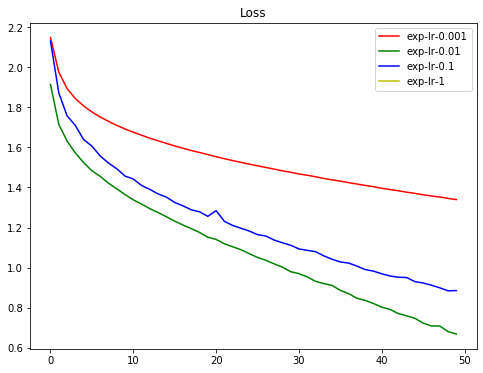

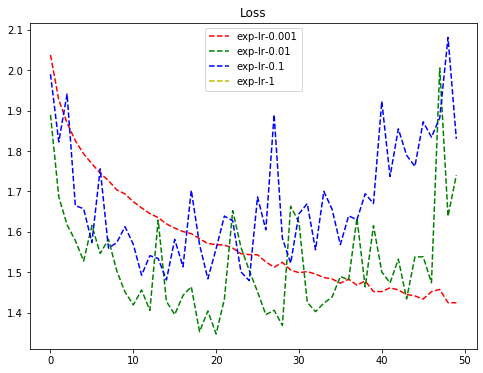

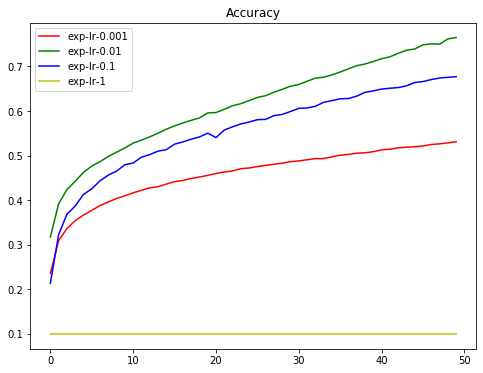

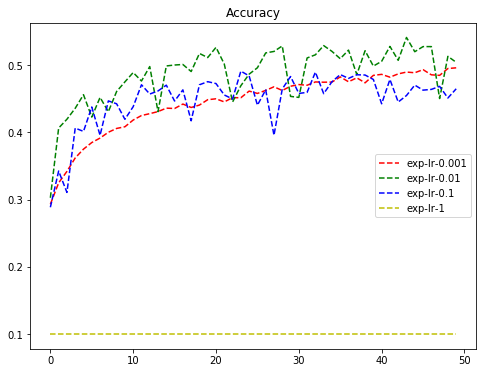

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()